In [2]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC

In [3]:
bucket_name="s1-bucket1"
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob=storage.blob.Blob("preprocessed_data.csv",bucket)
# Convert to a pandas dataframe
content = blob.download_as_string()
df = pd.read_csv(BytesIO(content))
df.dataframeName = "preprocessed_data.csv"

In [4]:
bucket_name="s1-bucket1"
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob2=storage.blob.Blob("wrangle.csv",bucket)
# Convert to a pandas dataframe
content2 = blob2.download_as_string()
data = pd.read_csv(BytesIO(content2))
data.dataframeName ="wrangle.csv"

## 0. Feature Importance

In [5]:
# Load file
#data = pd.read_csv("wrangle.csv", index_col=0)
# Specify independent and dependent variables
X = data.drop("Label", axis=1)
y = data.Label.values
# Data standardization
x_tool = StandardScaler()
x_std = x_tool.fit_transform(X)
# Use Catboost gains importance
num = 5
kf = KFold(num, random_state=1)
importance_catboost = np.zeros((X.shape[1], 1)).flatten()
for k, (train_index, test_index) in enumerate(kf.split(x_std, y)):
    x_train, x_test = x_std[train_index], x_std[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gbdt = CatBoostClassifier(eval_metric='AUC')
    gbdt.fit(x_train, y_train,
             eval_set=(x_test, y_test),
             verbose=0,
             use_best_model=True)
    importance_catboost = gbdt.feature_importances_.flatten() / num + importance_catboost
# svm gains importance of the features
estimator = LinearSVC(max_iter=10000)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1)
selector.fit(x_std, y)
importance_svm = selector.grid_scores_
importance_svm = importance_svm / np.sum(importance_svm) * 100
# Export results
result = pd.DataFrame({"features":X.columns,
              "importance of catboost": importance_catboost,
              "importance of svm":importance_svm})
print(result)
result.to_excel("feature selection.xlsx", index=False)

/home/xshen40/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


        features  importance of catboost  importance of svm
0     Unnamed: 0                0.418409           9.118333
1   danceability                0.296079           9.092731
2         energy                0.226389           9.090505
3       loudness                0.504930           9.086051
4    speechiness                0.204368           9.089392
5   acousticness                0.274886           9.086052
6       liveness                0.452813           9.089390
7        valence                0.321978           9.086052
8          tempo                0.231948           9.084939
9    duration_ms                0.246121           9.088278
10   sum_streams               96.822079           9.088278


In [9]:
#### We found "danceability","energy","loudness","speechiness" are the highest 4 features in the chart。We choose these 4 features to cluster.

## 1. First Round of Clustering
#### "danceability", "energy","loudness","speechiness"

In [13]:
#X=df[["acousticness","valence","duration_ms","loudness"]]
#X=df[["loudness","liveness","tempo","instrumentalness"]] 
X=df[["danceability", "energy","loudness","speechiness"]]

100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


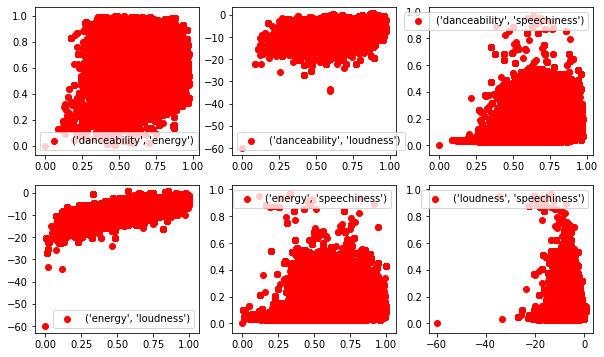

In [14]:
#name=["acousticness","valence","duration_ms","loudness"]
#name=["loudness","liveness","tempo","instrumentalness"]
name=["danceability", "energy","loudness","speechiness"]
a=list(itertools.combinations(name,2))
fig = plt.figure(figsize=(10,6))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(X.loc[:, a[i][0]], X.loc[:, a[i][1]],c = "red", marker='o', label=a[i])
    plt.legend()
plt.show()

100%|██████████| 14/14 [05:38<00:00, 24.19s/it]


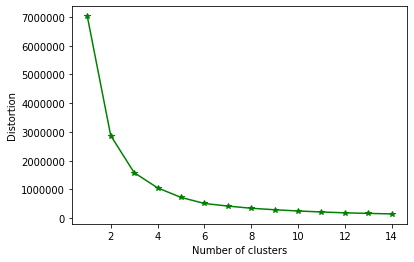

In [15]:
distortions=[]
for i in tqdm(range(1, 15)):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=0,n_jobs=-1)
        km.fit(X)
        distortions.append(km.inertia_)

plt.plot(range(1,15), distortions, marker='*',color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [16]:
### From the curve point of view, when the clustering is 4 or 5, it has a better effect. 
###  Considering the actual situation of our data, we choose cluster K value as 4

In [17]:
estimator = KMeans(n_clusters=4,n_jobs=-1) # Build K-means model
estimator.fit(X) # Cluster
label_pred = estimator.labels_ # Get cluster labels

In [18]:
# Draw K-means results
x0 = X[label_pred == 0]
x1 = X[label_pred == 1]
x2 = X[label_pred == 2]
x3 = X[label_pred == 3]

100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


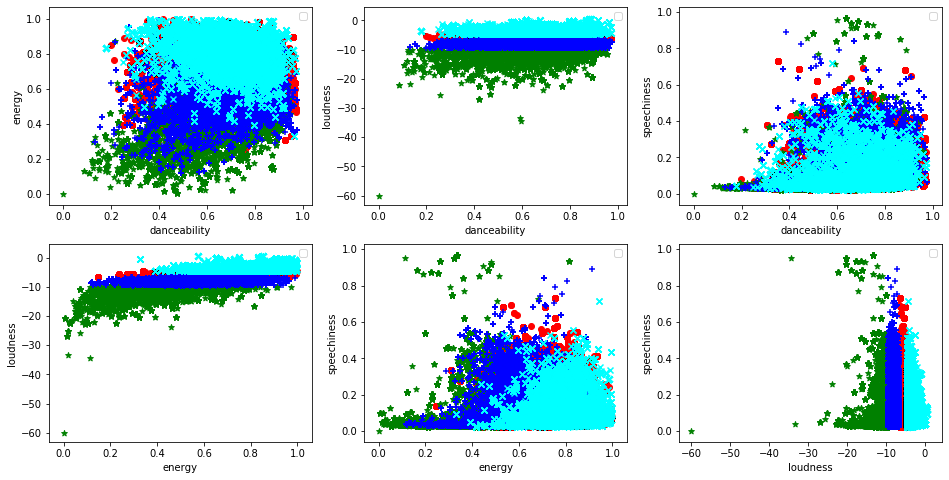

In [19]:
cols=["red","green","blue","cyan"]
a=list(itertools.combinations(name,2))
marker=["o","*","+","x"]
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(x0.loc[:, a[i][0]], x0.loc[:, a[i][1]], c = "red", marker='o')
    ax.scatter(x1.loc[:, a[i][0]], x1.loc[:, a[i][1]], c = "green", marker='*')
    ax.scatter(x2.loc[:, a[i][0]], x2.loc[:, a[i][1]], c = "blue", marker='+')
    ax.scatter(x3.loc[:, a[i][0]], x3.loc[:, a[i][1]], c = "cyan", marker='x')
    ax.set_xlabel(a[i][0])
    ax.set_ylabel(a[i][1])
    plt.legend()
plt.show()

## 2. Seond Round of Clustering
#### "loudness","liveness","tempo","instrumentalness"

In [10]:
#X=df[["acousticness","valence","duration_ms","loudness"]]
X=df[["loudness","liveness","tempo","instrumentalness"]] 
#X=df[["danceability", "energy","loudness","speechiness"]]

100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


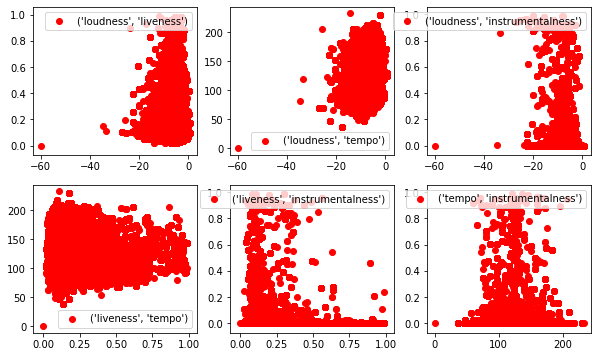

In [11]:
#name=["acousticness","valence","duration_ms","loudness"]
name=["loudness","liveness","tempo","instrumentalness"]
#name=["danceability", "energy","loudness","speechiness"]
a=list(itertools.combinations(name,2))
fig = plt.figure(figsize=(10,6))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(X.loc[:, a[i][0]], X.loc[:, a[i][1]],c = "red", marker='o', label=a[i])
    plt.legend()
plt.show()

100%|██████████| 14/14 [04:09<00:00, 17.80s/it]


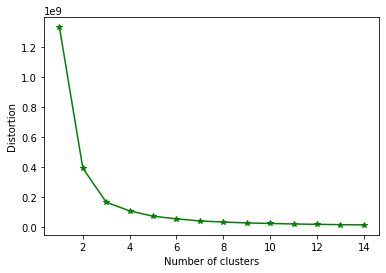

In [12]:
distortions=[]
for i in tqdm(range(1, 15)):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=0,n_jobs=-1)
        km.fit(X)
        distortions.append(km.inertia_)

plt.plot(range(1,15), distortions, marker='*',color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [13]:
### From the curve point of view, when the clustering is 4 or 5, it has a better effect. 
###  Considering the actual situation of our data, we choose cluster K value as 4

In [14]:
estimator = KMeans(n_clusters=4,n_jobs=-1) # Build K-means model
estimator.fit(X) # Cluster
label_pred = estimator.labels_ # Get cluster labels

In [15]:
# Draw K-means results
x0 = X[label_pred == 0]
x1 = X[label_pred == 1]
x2 = X[label_pred == 2]
x3 = X[label_pred == 3]

100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


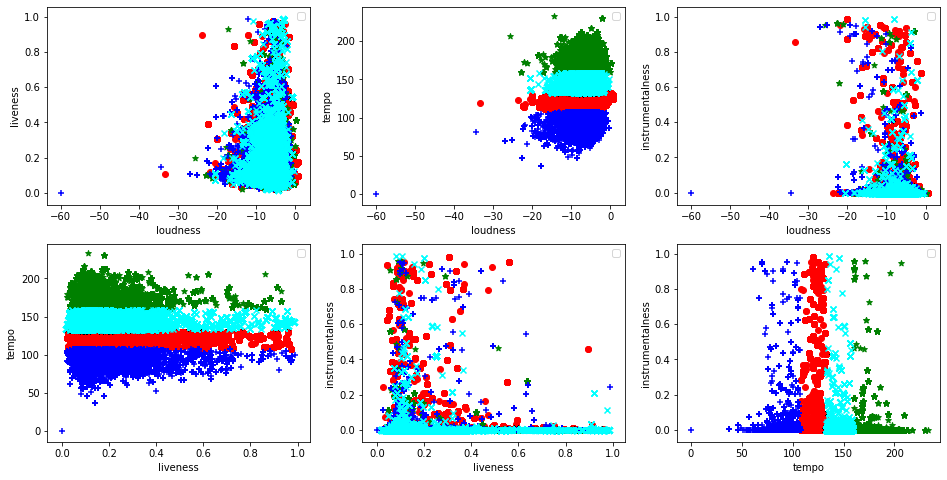

In [16]:
cols=["red","green","blue","cyan"]
a=list(itertools.combinations(name,2))
marker=["o","*","+","x"]
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(x0.loc[:, a[i][0]], x0.loc[:, a[i][1]], c = "red", marker='o')
    ax.scatter(x1.loc[:, a[i][0]], x1.loc[:, a[i][1]], c = "green", marker='*')
    ax.scatter(x2.loc[:, a[i][0]], x2.loc[:, a[i][1]], c = "blue", marker='+')
    ax.scatter(x3.loc[:, a[i][0]], x3.loc[:, a[i][1]], c = "cyan", marker='x')
    ax.set_xlabel(a[i][0])
    ax.set_ylabel(a[i][1])
    plt.legend()
plt.show()

In [17]:
### From the running results, when we use special diagnosis ludness and speech, the data characteristics are obvious. 
###   The data is easy to separate. In short, we only need two characteristics 
###      of ludness and speech to make decisions.

## 3. Third Round of Clustering
#### "acousticness","valence","duration_ms","loudness"

In [6]:
X=df[["acousticness","valence","duration_ms","loudness"]]
#X=df[["loudness","liveness","tempo","instrumentalness"]] 
#X=df[["danceability", "energy","loudness","speechiness"]]

100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


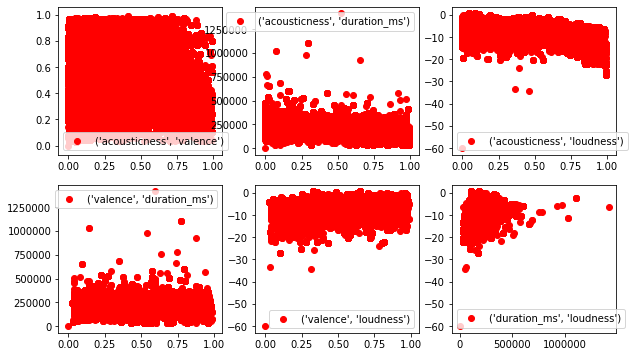

In [7]:
name=["acousticness","valence","duration_ms","loudness"]
#name=["loudness","liveness","tempo","instrumentalness"]
#name=["danceability", "energy","loudness","speechiness"]
a=list(itertools.combinations(name,2))
fig = plt.figure(figsize=(10,6))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(X.loc[:, a[i][0]], X.loc[:, a[i][1]],c = "red", marker='o', label=a[i])
    plt.legend()
plt.show()

100%|██████████| 14/14 [05:00<00:00, 21.46s/it]


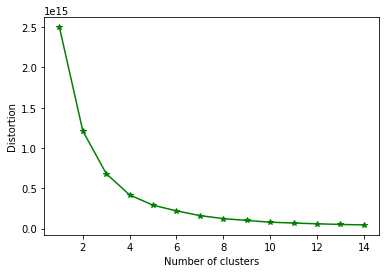

In [8]:
distortions=[]
for i in tqdm(range(1, 15)):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=0,n_jobs=-1)
        km.fit(X)
        distortions.append(km.inertia_)

plt.plot(range(1,15), distortions, marker='*',color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [9]:
### From the curve point of view, when the clustering is 4 or 5, it has a better effect. 
###  Considering the actual situation of our data, we choose cluster K value as 4

In [10]:
estimator = KMeans(n_clusters=4,n_jobs=-1) # Build K-means model
estimator.fit(X) # Cluster
label_pred = estimator.labels_ # Get cluster labels

In [11]:
# Draw K-means results
x0 = X[label_pred == 0]
x1 = X[label_pred == 1]
x2 = X[label_pred == 2]
x3 = X[label_pred == 3]

100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


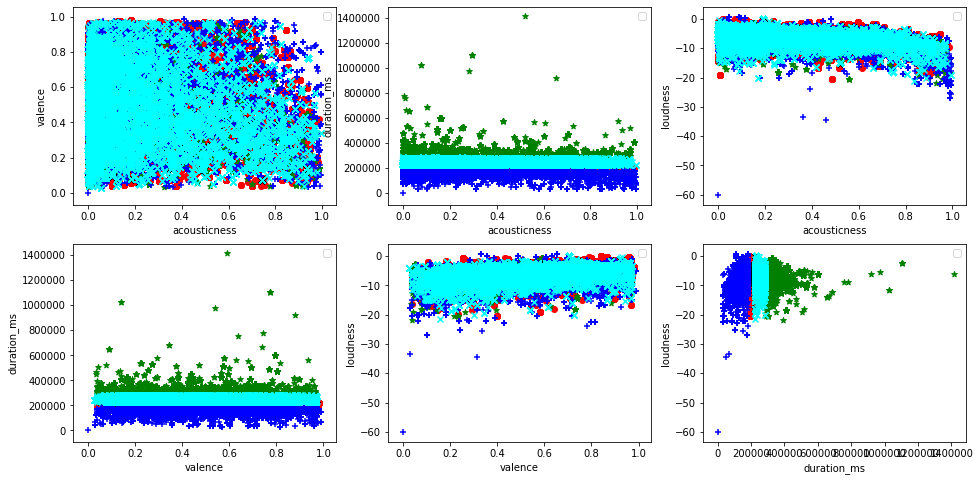

In [12]:
cols=["red","green","blue","cyan"]
a=list(itertools.combinations(name,2))
marker=["o","*","+","x"]
fig = plt.figure(figsize=(16,8))
for i in tqdm(range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(x0.loc[:, a[i][0]], x0.loc[:, a[i][1]], c = "red", marker='o')
    ax.scatter(x1.loc[:, a[i][0]], x1.loc[:, a[i][1]], c = "green", marker='*')
    ax.scatter(x2.loc[:, a[i][0]], x2.loc[:, a[i][1]], c = "blue", marker='+')
    ax.scatter(x3.loc[:, a[i][0]], x3.loc[:, a[i][1]], c = "cyan", marker='x')
    ax.set_xlabel(a[i][0])
    ax.set_ylabel(a[i][1])
    plt.legend()
plt.show()